In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
if tf.config.experimental.list_physical_devices('GPU'):
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_policy(policy)

# Step 2: Define paths and load images from Google Drive
image_path = '/content/drive/My Drive/Food Classification/'
image_dir = Path(image_path)
filepaths = list(image_dir.glob('**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [20]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)

# Step 4: Sample a subset of each category for balanced classes and shuffle
sampled_images = images.groupby('Label').sample(n=130, random_state=1)
sampled_images = sampled_images.sample(frac=1.0, random_state=1).reset_index(drop=True)


In [21]:
train_df, test_df = train_test_split(sampled_images, train_size=0.7, random_state=1)

# Step 6: Define ImageDataGenerators with data augmentation for training
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)


In [22]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

validation_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# Step 8: Load and configure ResNet50 with custom head for transfer learning
base_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model layers

# Custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(len(train_images.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

Found 1456 validated image filenames belonging to 20 classes.
Found 363 validated image filenames belonging to 20 classes.
Found 781 validated image filenames belonging to 20 classes.


In [23]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 9: Training with callbacks for learning rate reduction and early stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

history = model.fit(
    train_images,
    validation_data=validation_images,
    epochs=15,
    callbacks=callbacks
)

# Step 10: Fine-tuning by unfreezing last few layers and retraining with lower learning rate
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_images,
    validation_data=validation_images,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 373s 8s/step - accuracy: 0.2538 - loss: 2.6124 - val_accuracy: 0.5840 - val_loss: 1.3726 - learning_rate: 0.0010
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 378s 8s/step - accuracy: 0.7009 - loss: 1.0086 - val_accuracy: 0.7163 - val_loss: 0.9805 - learning_rate: 0.0010
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 371s 7s/step - accuracy: 0.8321 - loss: 0.6113 - val_accuracy: 0.6832 - val_loss: 1.0791 - learning_rate: 0.0010
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 358s 8s/step - accuracy: 0.8644 - loss: 0.4914 - val_accuracy: 0.7273 - val_loss: 0.9342 - learning_rate: 0.0010
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 366s 8s/step - accuracy: 0.8888 - loss: 0.3645 - val_accuracy: 0.7328 - val_loss: 0.9139 - learning_rate: 0.0010
Epoch 6/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 376s 8s/step - accuracy: 0.9050 - loss: 0.3426 - val_accuracy: 0.7521 - val_loss: 0.8501 - learning_rate: 0.0010
Epoch 7/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 399s 9s/step - accuracy: 0.9291 - loss: 0.2323 - val_accuracy: 0.76

In [24]:
test_loss, test_accuracy = model.evaluate(test_images, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 81.05%


In [25]:
predictions = np.argmax(model.predict(test_images), axis=1)
true_labels = test_images.labels
class_labels = list(test_images.class_indices.keys())

# Confusion matrix and classification report
cm = confusion_matrix(true_labels, predictions)
clr = classification_report(true_labels, predictions, target_names=class_labels, zero_division=0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 153s 6s/step


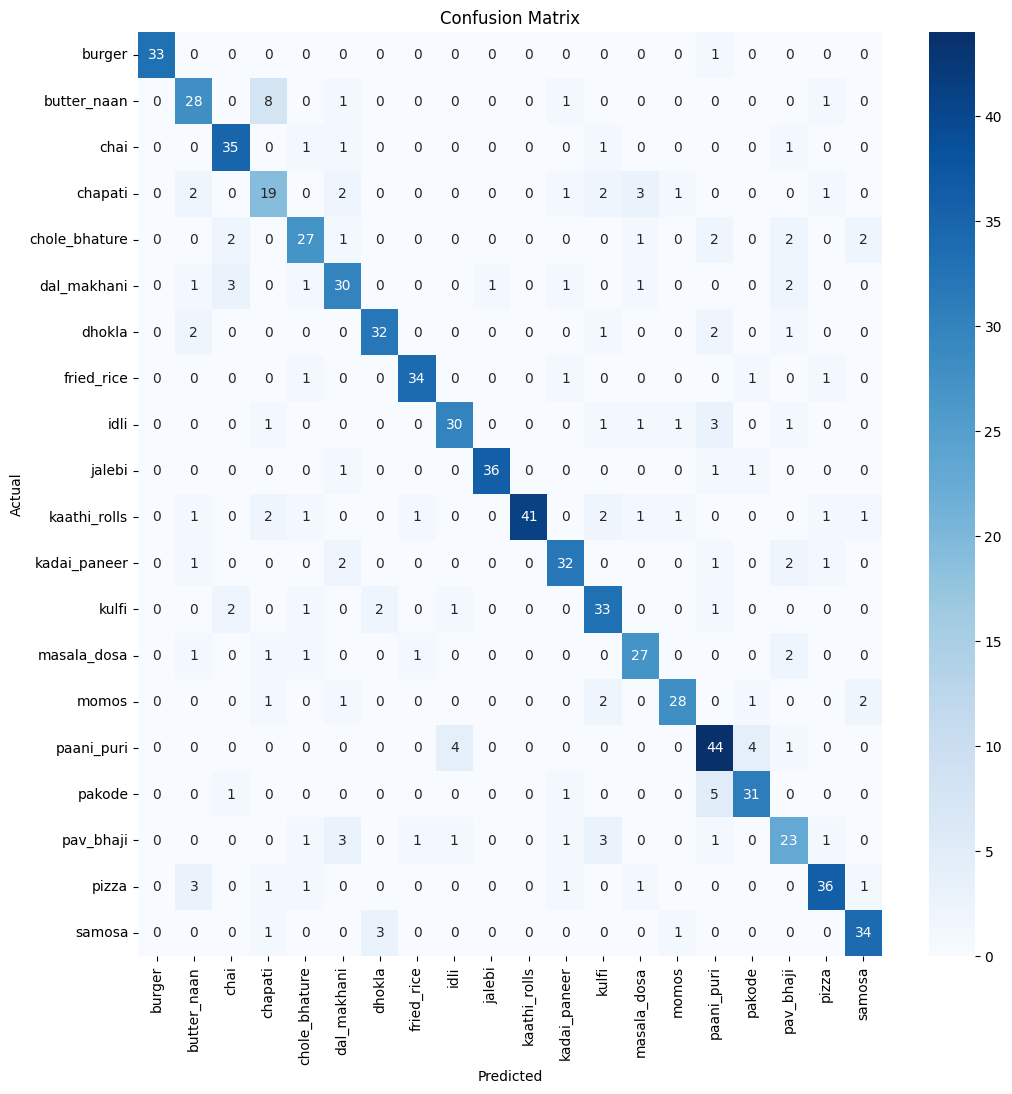

In [26]:
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [27]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                precision    recall  f1-score   support

       burger       1.00      0.97      0.99        34
  butter_naan       0.72      0.72      0.72        39
         chai       0.81      0.90      0.85        39
      chapati       0.56      0.61      0.58        31
chole_bhature       0.77      0.73      0.75        37
  dal_makhani       0.71      0.75      0.73        40
       dhokla       0.86      0.84      0.85        38
   fried_rice       0.92      0.89      0.91        38
         idli       0.83      0.79      0.81        38
       jalebi       0.97      0.92      0.95        39
 kaathi_rolls       1.00      0.79      0.88        52
 kadai_paneer       0.82      0.82      0.82        39
        kulfi       0.73      0.82      0.78        40
  masala_dosa       0.77      0.82      0.79        33
        momos       0.88      0.80      0.84        35
   paani_puri       0.72      0.83      0.77        53
       pakode    

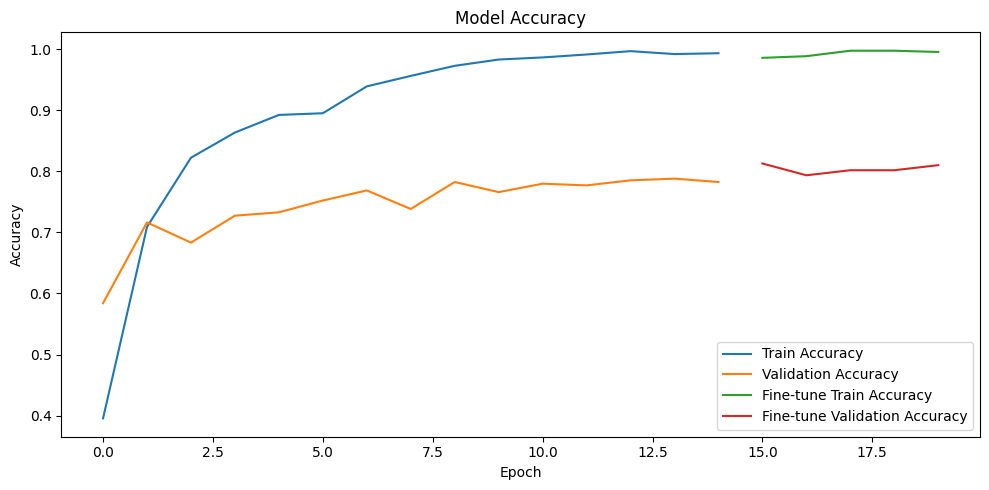

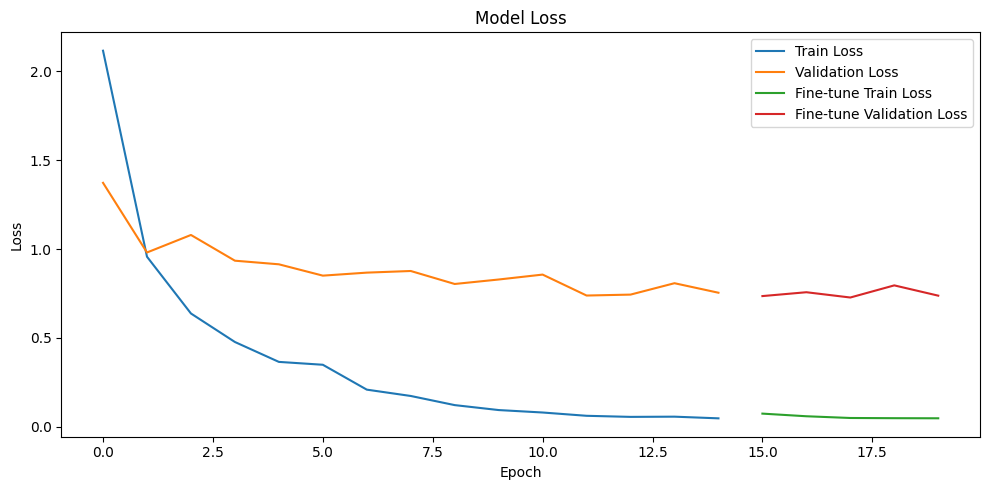

In [28]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
if 'fine_tune_history' in locals():  # Check if fine_tune_history exists
    plt.plot(np.arange(len(history.history['accuracy']), len(history.history['accuracy']) + len(fine_tune_history.history['accuracy'])),
             fine_tune_history.history['accuracy'], label='Fine-tune Train Accuracy')
    plt.plot(np.arange(len(history.history['val_accuracy']), len(history.history['val_accuracy']) + len(fine_tune_history.history['val_accuracy'])),
             fine_tune_history.history['val_accuracy'], label='Fine-tune Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
if 'fine_tune_history' in locals():  # Check if fine_tune_history exists
    plt.plot(np.arange(len(history.history['loss']), len(history.history['loss']) + len(fine_tune_history.history['loss'])),
             fine_tune_history.history['loss'], label='Fine-tune Train Loss')
    plt.plot(np.arange(len(history.history['val_loss']), len(history.history['val_loss']) + len(fine_tune_history.history['val_loss'])),
             fine_tune_history.history['val_loss'], label='Fine-tune Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
